# 🧩 6. Analisis Lanjutan Menggunakan BERTopic (X - Ulasan Negatif)

## Instalasi Library

In [1]:
%pip install bertopic[all] umap-learn hdbscan Sastrawi
%pip install sentence-transformers

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


## Import Library & Inisialisasi

In [2]:
from bertopic import BERTopic
import pandas as pd
import matplotlib.pyplot as plt
import re

### Memanggil Dataset Tiktok

In [3]:
# Load CSV lokal
file_path = "Dataset/label_indobert_x.csv"  # pastikan path sesuai lokasi file
df = pd.read_csv(file_path)
df.head()

,comment,case_folding,cleaning,normalisasi,tokenisasi,stopword_removal,stemming,score,sentiment_label,sentiment_encoded,bert_encoded,bert_label
0,byond bsi gangguan gasih? gw topup shopay uda...,byond bsi gangguan gasih? gw topup shopay uda...,byond bsi gangguan gasih gw topup shopay udah...,byond bsi masalah tidak sih gue isi ulang shop...,"['byond', 'bsi', 'masalah', 'tidak', 'sih', 'g...","['masalah', 'tidak', 'sih', 'gue', 'isi', 'ula...","['masalah', 'tidak', 'sih', 'gue', 'isi', 'ula...",-4,Negatif,0,0,negatif
1,@blurbintang @worksfess Kalau kasus byond aku ...,@blurbintang @worksfess kalau kasus byond aku ...,kalau kasus byond aku kurang copy kak,kalau kasus byond akun kurang copy kak,"['kalau', 'kasus', 'byond', 'akun', 'kurang', ...","['akun', 'kurang', 'copy']","['akun', 'kurang', 'copy']",-1,Negatif,0,0,negatif
2,Halo min @bankbsi_id Saya melakukan pembayar s...,halo min @bankbsi_id saya melakukan pembayar s...,halo min saya melakukan pembayar shopee melal...,halo min saya melakukan pembayar shopee melalu...,"['halo', 'min', 'saya', 'melakukan', 'pembayar...","['min', 'pembayar', 'shopee', 'kali', 'statusn...","['min', 'bayar', 'shopee', 'kali', 'status', '...",3,Positif,1,1,positif
3,@asknownasaqueen @worksfess Kak nitip prtnyaan...,@asknownasaqueen @worksfess kak nitip prtnyaan...,kak nitip prtnyaan please ak mau nyoba nabun...,kak nitip prtnyaan please aku mau mencoba nabu...,"['kak', 'nitip', 'prtnyaan', 'please', 'aku', ...","['nitip', 'prtnyaan', 'please', 'mencoba', 'na...","['nitip', 'prtnyaan', 'please', 'coba', 'nabun...",-1,Negatif,0,0,negatif
4,@bankbsi_id min kok aplikasi byond by bsi gk b...,@bankbsi_id min kok aplikasi byond by bsi gk b...,min kok aplikasi byond by bsi gk bisa dibuka ...,min kok aplikasi byond by bsi tidak bisa dibuk...,"['min', 'kok', 'aplikasi', 'byond', 'by', 'bsi...","['min', 'aplikasi', 'tidak', 'dibuka', 'siang'...","['min', 'aplikasi', 'tidak', 'buka', 'siang', ...",-3,Negatif,0,0,negatif


In [4]:
df_positif = df[df["bert_label"] == "positif"].copy()
print("Jumlah Ulasan Positif:", len(df_positif))

Jumlah Ulasan Positif: 2144


In [5]:
df_negatif = df[df["bert_label"] == "negatif"].copy()
print("Jumlah Ulasan Negatif:", len(df_negatif))

Jumlah Ulasan Negatif: 2426


In [6]:
import re
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# --- stopword dasar dari Sastrawi ---
factory = StopWordRemoverFactory()
base_stopwords = set(factory.get_stop_words())

# --- stopword tambahan untuk data TikTok (super lengkap) ---
extra_stopwords = {
    # kata panggilan
    "kak", "kakak", "bang", "bro", "sis", "bos", "min", "admin",

    # nama aplikasi & banking
    "bsi", "byond", "beyond", "wondr", "bni", "mbanking", "mobile", "bank", "byondbybsi", "beyondbsii",

    # kata bantu umum yang tidak bermakna topik
    "bisa", "tidak", "ga", "gak", "gk", "nggak", "ngga", "enggak",
    "iya", "kayak", "gua", "gue", "aku", "kamu", "anda", "mereka",
    "saya", "mau", "udah", "lagi", "yang", "dengan", "agar", "jadi",

    # kata noise umum TikTok
    "anjir", "anjay", "banget", "parah", "loh", "lah", "kok", "sih",
    "wkwk", "wkwkwk", "hehe", "haha", "hmm",

    # corporate / lokasi bias
    "tbk", "pt", "aceh", "indonesia",

    # Tambahan kata umum lainnya
    "hari", "kalau", "cont", "silakan", "lalu", "menggunakan", "pastikan", "restart", "selalu", "playstore", "appstore", "berbagi", "keren", "bekerjasama", "outlet", "dilihat", "terupdate",
    "berhatihati", "jaga", "mengatasnamakan", "mohon", "versi", "pribadi", "syariah", "paham", "jadi", "berkah", "ikutan", "icon", " jawabannya", "logo", " ialah", "update", "coba", "melakukan",
    "waalaikumsalam", " kuisnya", "minsy", "kali", "mluu", "mint", "enih", "guys", "info", "begini", "mohon", "kata", "terbaru", "memberikan", "pihak", "waspada", "himbau", "stabil", "overlapping",
    "menjaga", "keharasiaan", "manapun", " ", "diperbarui", "terlebih", "kuis", "jawaban", "follow", "rezeki", "bestie", "pahamjadiberkah", "jangan", "klik", "link", "resmi", "benar", "menindaklanjuti",
}

# gabungkan semua stopword
all_stopwords = base_stopwords.union(extra_stopwords)

# --- CLEANING SUPER KOMPREHENSIF UNTUK BERTopic ---
def clean_bertopic(text):
    text = str(text).lower()

    # hapus URL, @mention, hashtag
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", " ", text)

    # hapus karakter selain huruf/angka/spasi
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)

    # hapus kata 1–3 huruf (mengurangi bias X)
    text = re.sub(r"\b\w{1,3}\b", " ", text)

    # stopword filter
    tokens = [w for w in text.split() if w not in all_stopwords]

    return " ".join(tokens).strip()

In [7]:
df_negatif["clean_text"] = df_negatif["normalisasi"].apply(clean_bertopic)
df_negatif[["normalisasi", "clean_text"]].head()

,normalisasi,clean_text
0,byond bsi masalah tidak sih gue isi ulang shop...,masalah ulang shopay menit disuruh menunggu ma...
1,kalau kasus byond akun kurang copy kak,kasus akun kurang copy
3,kak nitip prtnyaan please aku mau mencoba nabu...,nitip prtnyaan please mencoba nabung emas hrga...
4,min kok aplikasi byond by bsi tidak bisa dibuk...,aplikasi dibuka siang makan
5,baik terima kasih omong-omong kartu atm bsi sa...,baik terima kasih omong omong kartu hilang buk...


In [8]:
# 5. EMBEDDING MODEL TERBAIK
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")

In [9]:
# 6. BERTopic MODEL

topic_model = BERTopic(
    embedding_model=embedding_model,
    language="indonesian",
    min_topic_size=40,     # cluster minimal agar topik stabil
    nr_topics="4"       # otomatis menentukan jumlah topik
)

topics, probs = topic_model.fit_transform(df_negatif["clean_text"])

df_negatif["topic"] = topics

In [10]:
# 7. TOPIC INFO

topic_info = topic_model.get_topic_info()
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,726,-1_data_sekarang_lebih_aplikasi,"[data, sekarang, lebih, aplikasi, sandi, error...","[sekarang data sandi kode, fitur lebih lengkap..."
1,0,675,0_error_mulu_terus_masalah,"[error, mulu, terus, masalah, pakai, masuk, ka...","[error mulu, error mulu, error mulu]"
2,1,582,1_akun_kartu_transaksi_aplikasi,"[akun, kartu, transaksi, aplikasi, masuk, reke...",[pelaporan transaksi lewat aplikasi soalnya ak...
3,2,400,2_aplikasi_error_lama_pakai,"[aplikasi, error, lama, pakai, terus, baru, bu...","[aplikasi, aplikasi, aplikasi]"
4,3,43,3_aplikasi_cache_handphone_force,"[aplikasi, cache, handphone, force, hapus, tut...",[mendatapati masalah lakukan langkah berikut f...


In [11]:
# 8. PRINT KEYWORDS PER TOPIK

print("=== Keywords for All Topics ===")
for topic_id in topic_info["Topic"]:
    if topic_id == -1:   # skip outlier jika mau
        continue
    print(f"\nTOPIC {topic_id}")
    print(topic_model.get_topic(topic_id))

=== Keywords for All Topics ===

TOPIC 0
[('error', np.float64(0.14535889491063436)), ('mulu', np.float64(0.09396629459010056)), ('terus', np.float64(0.05613240484415024)), ('masalah', np.float64(0.05445241199256249)), ('pakai', np.float64(0.045890580487404214)), ('masuk', np.float64(0.04344726263001368)), ('kapan', np.float64(0.04229978449178851)), ('sama', np.float64(0.037475221253354896)), ('memang', np.float64(0.035440359979606595)), ('kemarin', np.float64(0.03453297632165226))]

TOPIC 1
[('akun', np.float64(0.08784620819509757)), ('kartu', np.float64(0.05821113901441827)), ('transaksi', np.float64(0.04922360147530313)), ('aplikasi', np.float64(0.04800213801787666)), ('masuk', np.float64(0.04797839461414218)), ('rekening', np.float64(0.04663369978784841)), ('uang', np.float64(0.04648331313278732)), ('pakai', np.float64(0.04584344416115157)), ('error', np.float64(0.042581900023734895)), ('bayar', np.float64(0.03910449881714371))]

TOPIC 2
[('aplikasi', np.float64(0.1992901320126833)

In [14]:
# 1. Define custom topic names
custom_labels = {
    0: "Error & Masalah Stabilitas",
    1: "Fitur & Transaksi Aplikasi",
    2: "Performa & Responsiveness",
    3: "Maintenance & Pengalaman Pengguna"
}

# 2. Apply rename to topic model
topic_model.set_topic_labels(custom_labels)

# 3. Print renamed topics + keywords
print("\n=== TOPIK & KEYWORDS SETELAH RENAME ===")
for topic_id, keywords in topic_model.get_topics().items():
    if topic_id == -1:
        continue
    print(f"\nTOPIC {topic_id} — {custom_labels[topic_id]}")
    print(keywords)


# 4. Mapping ke Aspek Penelitian
aspek_mapping = {
    0: "Aspek 1: Error & Masalah Stabilitas",
    1: "Aspek 2: Fitur & Transaksi Aplikasi",
    2: "Aspek 3: Performa & Responsiveness",
    3: "Aspek 4: Maintenance & Pengalaman Pengguna"
}

print("\n=== ASPEK PER TOPIK ===")
for topic_id, aspek in aspek_mapping.items():
    print(f"TOPIC {topic_id} → {aspek}")


=== TOPIK & KEYWORDS SETELAH RENAME ===

TOPIC 0 — Error & Masalah Stabilitas
[('error', np.float64(0.14535889491063436)), ('mulu', np.float64(0.09396629459010056)), ('terus', np.float64(0.05613240484415024)), ('masalah', np.float64(0.05445241199256249)), ('pakai', np.float64(0.045890580487404214)), ('masuk', np.float64(0.04344726263001368)), ('kapan', np.float64(0.04229978449178851)), ('sama', np.float64(0.037475221253354896)), ('memang', np.float64(0.035440359979606595)), ('kemarin', np.float64(0.03453297632165226))]

TOPIC 1 — Fitur & Transaksi Aplikasi
[('akun', np.float64(0.08784620819509757)), ('kartu', np.float64(0.05821113901441827)), ('transaksi', np.float64(0.04922360147530313)), ('aplikasi', np.float64(0.04800213801787666)), ('masuk', np.float64(0.04797839461414218)), ('rekening', np.float64(0.04663369978784841)), ('uang', np.float64(0.04648331313278732)), ('pakai', np.float64(0.04584344416115157)), ('error', np.float64(0.042581900023734895)), ('bayar', np.float64(0.0391044

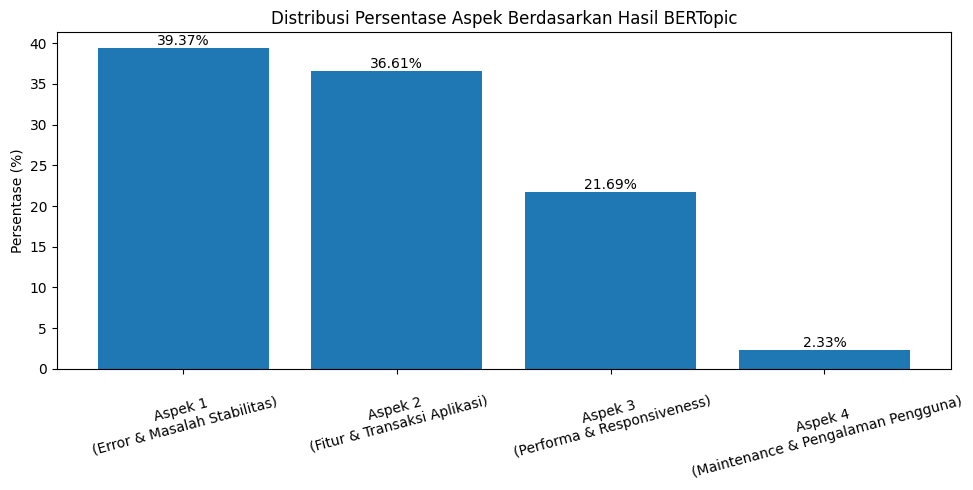

In [15]:
import matplotlib.pyplot as plt

# === DATA TOPIK (tanpa topik -1) ===
topic_counts = {
    "Aspek 1\n(Error & Masalah Stabilitas)": 726,      # Topic 0
    "Aspek 2\n(Fitur & Transaksi Aplikasi)": 675, # Topic 1
    "Aspek 3\n(Performa & Responsiveness)": 400,  # Topic 2
    "Aspek 4\n(Maintenance & Pengalaman Pengguna)": 43 # Topic 3
}

# === HITUNG PERSENTASE ===
total = sum(topic_counts.values())
percentages = {k: (v / total) * 100 for k, v in topic_counts.items()}

# === VISUALISASI DIAGRAM BATANG ===
plt.figure(figsize=(10, 5))

bars = plt.bar(
    list(percentages.keys()),
    list(percentages.values())
)

# Label
plt.ylabel("Persentase (%)")
plt.title("Distribusi Persentase Aspek Berdasarkan Hasil BERTopic")
plt.xticks(rotation=15)

# Tambahkan label persentase di atas batang
for bar, perc in zip(bars, percentages.values()):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{perc:.2f}%",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()